<a href="https://colab.research.google.com/github/cowliciouslyn/kppboom2025/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# ============================
# 1️⃣ Import Library
# ============================
import pandas as pd                           # untuk membaca & mengolah data
import matplotlib.pyplot as plt               # visualisasi dasar
import seaborn as sns                         # visualisasi yang lebih cantik
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # normalisasi
from sklearn.metrics import silhouette_score  # evaluasi clustering nanti
from sklearn.cluster import KMeans            # algoritma clustering
from sklearn.decomposition import PCA         # reduksi dimensi (visualisasi)
from mpl_toolkits.mplot3d import Axes3D       # untuk membuat visualisasi 3D
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings("ignore")


In [ ]:

# Specify the correct path to the file in your Google Drive
path = "/content/drive/My Drive/TUGAS BOOM/Mall_Customers.csv"
data = pd.read_csv(path)

data.head()                                 #menampilkan 5 baris pertama

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
# ============================
# 4️⃣ Cek Informasi Data
# ============================
print("Jumlah baris dan kolom:", data.shape)
print("\nTipe data tiap kolom:\n", data.dtypes)
print("\nJumlah missing values:\n", data.isnull().sum())
print("\nJumlah duplikat:", data.duplicated().sum())


Jumlah baris dan kolom: (200, 5)

Tipe data tiap kolom:
 CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

Jumlah missing values:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Jumlah duplikat: 0


EDA

In [ ]:
# 2) Basic EDA
print(data.info()) #menampilkan struktur dataset
print(data.describe()) #menampilkan statistik deskriptif
print("Missing values per column:\n", data.isna().sum()) #menampilkan apakah ada nilai kosong (missing value)
print("Duplicates:", data.duplicated().sum())
for col in data.columns:
    print(col, "unique:", data[col].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000    

Visualisasi Data

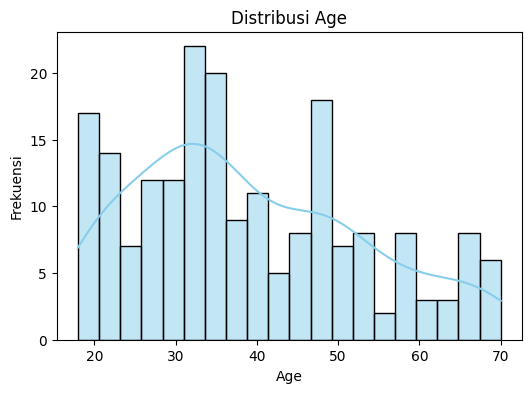

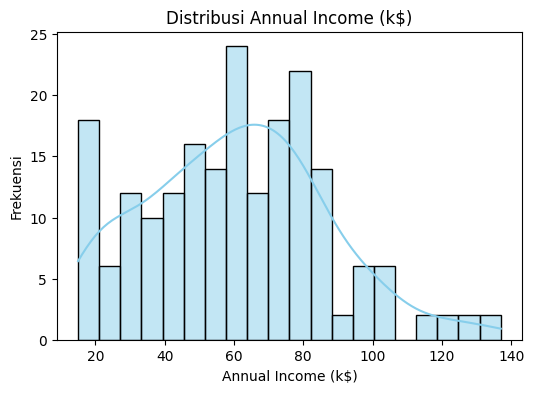

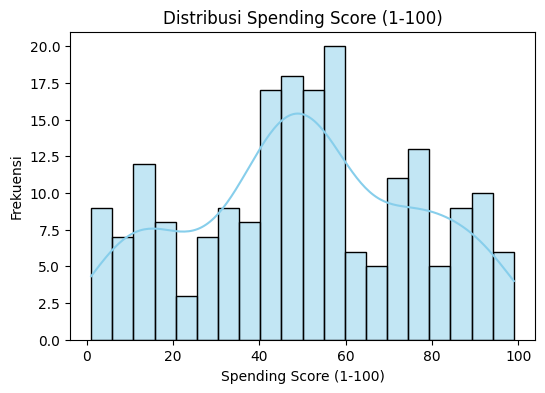

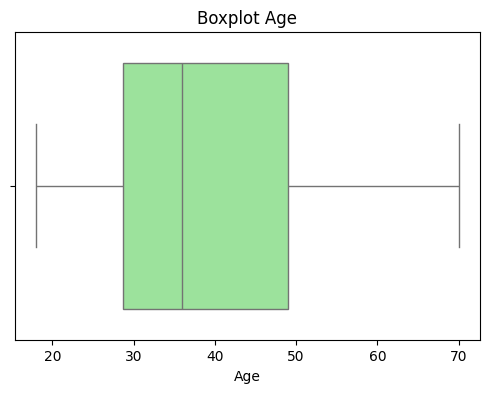

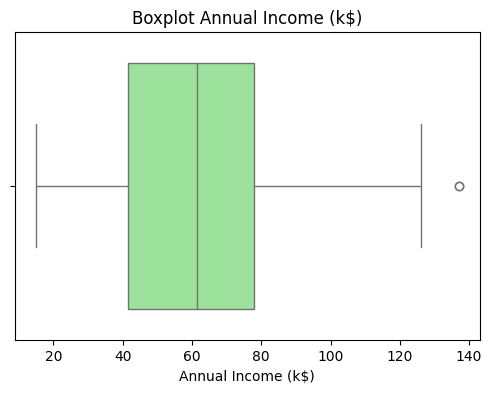

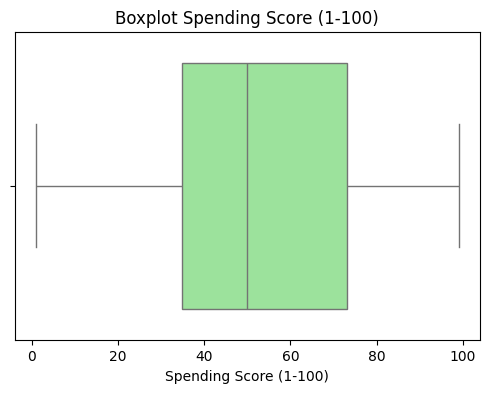

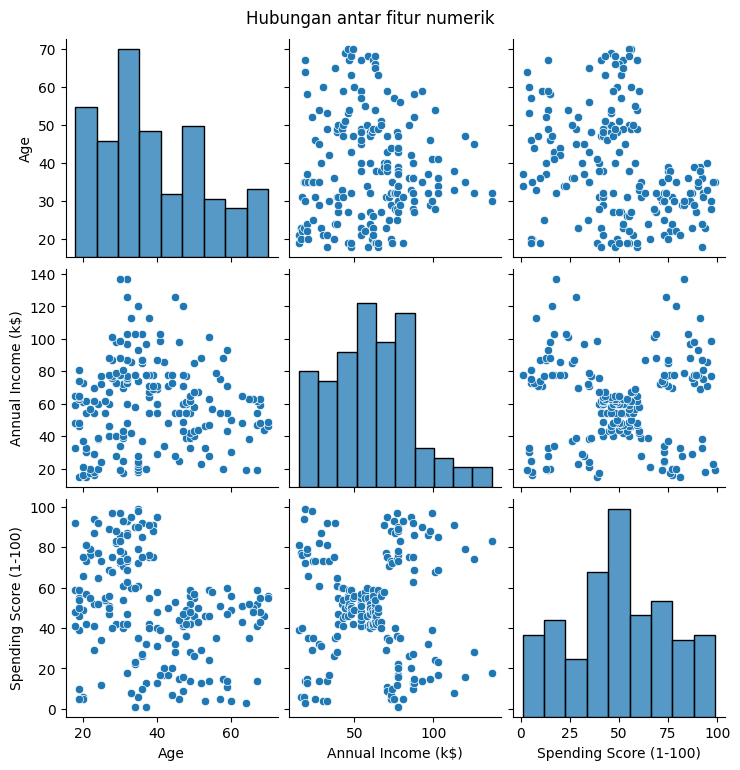

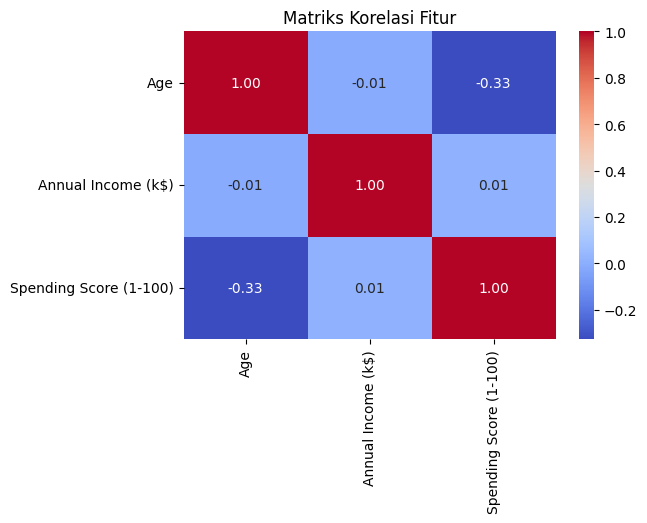


Data fitur yang akan digunakan untuk clustering:
        Age  Annual Income (k$)  Spending Score (1-100)
0 -1.424569           -1.738999               -0.434801
1 -1.281035           -1.738999                1.195704
2 -1.352802           -1.700830               -1.715913
3 -1.137502           -1.700830                1.040418
4 -0.563369           -1.662660               -0.395980


In [ ]:
# === Langkah 2: Analisis Fitur ===

# 1. Lihat distribusi tiap fitur (histogram)
num_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)'] #membuat list nama kolom

for col in num_cols:
    plt.figure(figsize=(6,4)) #membuat canvas untuk tiap plot, ukuran 6x4 inch
    sns.histplot(data[col], bins=20, kde=True, color='skyblue') #menggambar histogram untuk kolom tertentu
    plt.title(f'Distribusi {col}') #judul grafik
    plt.xlabel(col) #nama sumbu x
    plt.ylabel('Frekuensi') #namba sumbu y
    plt.show() #menampilkan plot

# 2. Boxplot untuk mendeteksi outlier
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col], color='lightgreen')
    plt.title(f'Boxplot {col}')
    plt.show()

# 3. Analisis hubungan antar fitur (scatter plot)
sns.pairplot(data[num_cols])
plt.suptitle('Hubungan antar fitur numerik', y=1.02)
plt.show()

# 4. Korelasi antar fitur
plt.figure(figsize=(6,4))
sns.heatmap(data[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriks Korelasi Fitur")
plt.show()

# 5. Normalisasi fitur dan pilih fitur penting
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

data_scaled = data.copy()
data_scaled[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] = scaler.fit_transform(
    data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]
)

selected_features = data_scaled[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

print("\nData fitur yang akan digunakan untuk clustering:")
print(selected_features.head())


In [ ]:
# ============================
# 7️⃣ Normalisasi Data
# ============================
# Ambil fitur numerik yang relevan untuk clustering
X = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Normalisasi pakai StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cek hasil normalisasi (5 baris pertama)
pd.DataFrame(X_scaled, columns=X.columns).head()

,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


In [ ]:
# === 8) Metode Elbow & Silhouette ===
list_n = range(2, 11)
inertias = []
silhouettes = []

for n in list_n:
    km = KMeans(n_clusters=n, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, km.labels_))

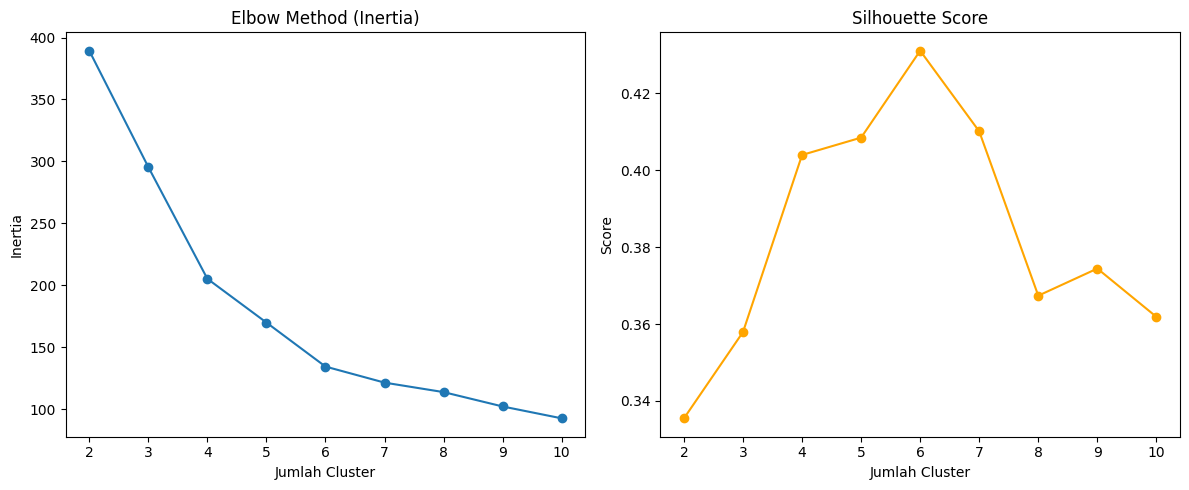

In [ ]:
# === 9) Plot Elbow dan Silhouette ===
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(list_n, inertias, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(list_n, silhouettes, marker='o', color='orange')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Score')

plt.tight_layout()
plt.show()


Baseline Model

Silhouette Score (Baseline Random): -0.0692
Inertia (SSE) Estimasi: 262255.2207


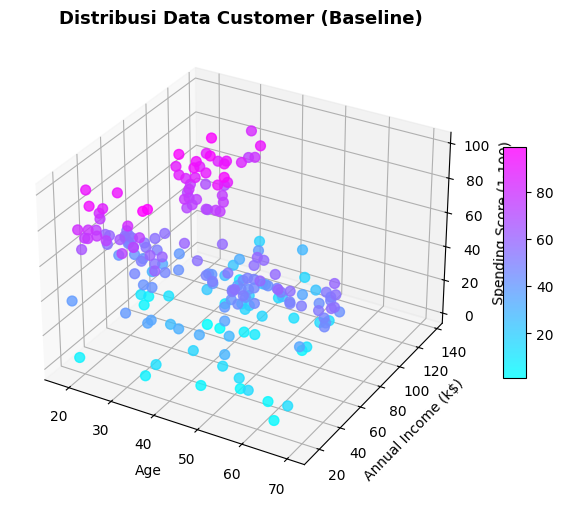

In [ ]:
import numpy as np
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assume X is already defined and contains the features
# For demonstration, I'll use the X from the previous cells
# X = data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # This line is commented out as X is already in the notebook state

# --- Buat cluster acak (misal 5 cluster acak) ---
np.random.seed(42)
n_clusters = 5
random_labels = np.random.randint(0, n_clusters, size=len(X))

# --- Hitung metrik evaluasi ---
sil_score = silhouette_score(X, random_labels)
print(f"Silhouette Score (Baseline Random): {sil_score:.4f}")

# inertia (SSE) tidak relevant for random cluster, tapi kita bisa estimasi manual:


centroids = np.array([X[random_labels == i].mean(axis=0) for i in range(n_clusters)])
_, distances = pairwise_distances_argmin_min(X, centroids)
inertia = np.sum(distances**2)
print(f"Inertia (SSE) Estimasi: {inertia:.4f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X['Age'],
    X['Annual Income (k$)'],
    X['Spending Score (1-100)'],
    c=X['Spending Score (1-100)'],  # gradasi warna dari Spending Score
    cmap='cool',
    s=50,
    alpha=0.8
)

ax.set_title('Distribusi Data Customer (Baseline)', fontsize=13, fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
plt.show()

K-Means

K-Means Inertia (SSE): 169.89
K-Means Silhouette Score: 0.408


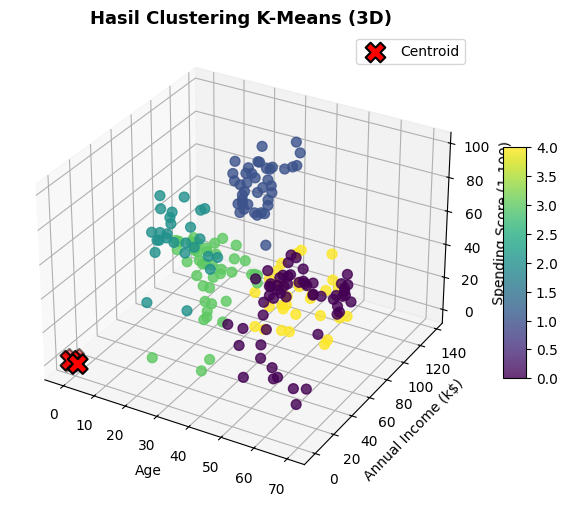

In [ ]:
# ======================================================
# 2️⃣ K-MEANS CLUSTERING
# ======================================================
# Tentukan jumlah cluster optimal dulu (misal k=5 dari hasil elbow/silhouette)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
labels_kmeans = kmeans.labels_

# Evaluasi K-Means
inertia = kmeans.inertia_
sil_score_kmeans = silhouette_score(X_scaled, labels_kmeans)

print(f"K-Means Inertia (SSE): {inertia:.2f}")
print(f"K-Means Silhouette Score: {sil_score_kmeans:.3f}")

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X['Age'],
    X['Annual Income (k$)'],
    X['Spending Score (1-100)'],
    c=kmeans.labels_,
    cmap='viridis',
    s=50,
    alpha=0.8
)

# Tambahkan titik centroid
centroids = kmeans.cluster_centers_
ax.scatter(
    centroids[:, 0],
    centroids[:, 1],
    centroids[:, 2],
    s=200,
    c='red',
    marker='X',
    edgecolor='black',
    linewidth=1.5,
    label='Centroid'
)

ax.set_title('Hasil Clustering K-Means (3D)', fontsize=13, fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.legend()
fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
plt.show()


DBSCAN


DBSCAN Jumlah Cluster: 1
DBSCAN Jumlah Noise: 6
DBSCAN Silhouette Score: Tidak bisa dihitung (hanya 1 cluster)


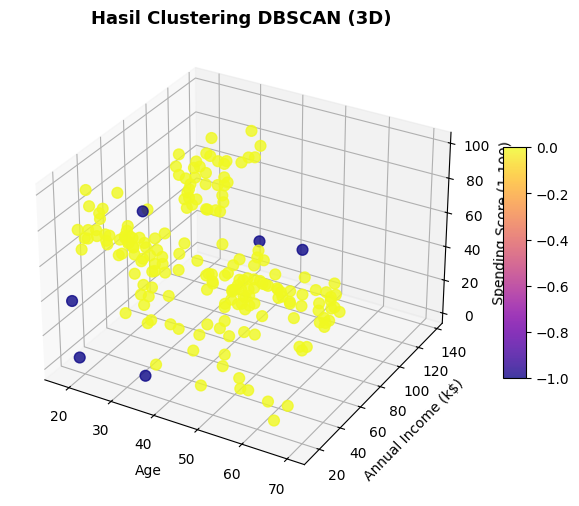

Label cluster DBSCAN: {np.int64(0), np.int64(-1)}


In [ ]:
# ======================================================
# 3️⃣ DBSCAN CLUSTERING
# ======================================================

# Cek jumlah cluster (selain noise)
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

# Evaluasi DBSCAN
if n_clusters_dbscan > 1:
    sil_score_dbscan = silhouette_score(X_scaled, labels_dbscan)
else:
    sil_score_dbscan = None

print(f"\nDBSCAN Jumlah Cluster: {n_clusters_dbscan}")
print(f"DBSCAN Jumlah Noise: {n_noise}")
if sil_score_dbscan:
    print(f"DBSCAN Silhouette Score: {sil_score_dbscan:.3f}")
else:
    print("DBSCAN Silhouette Score: Tidak bisa dihitung (hanya 1 cluster)")

# === Model DBSCAN ===
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Tambahkan hasil cluster ke dataframe
X['Cluster_DBSCAN'] = labels_dbscan

# === Visualisasi 3D hasil DBSCAN ===
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    X['Age'],
    X['Annual Income (k$)'],
    X['Spending Score (1-100)'],
    c=labels_dbscan,
    cmap='plasma',
    s=60,
    alpha=0.8
)

ax.set_title('Hasil Clustering DBSCAN (3D)', fontsize=13, fontweight='bold')
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
fig.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
plt.show()

# Cek label cluster
print("Label cluster DBSCAN:", set(labels_dbscan))

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        2  
1        2  
2        4  
3        2  
4        4  


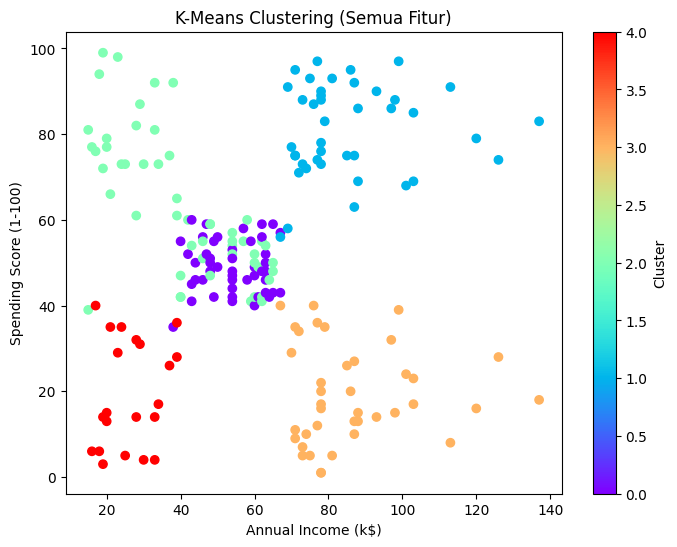

In [ ]:
# 2. Pilih semua fitur numerik
features = data.select_dtypes(include=['int64', 'float64'])

# 3. Standarisasi fitur (supaya skala datanya seimbang)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 4. Tentukan jumlah cluster (misalnya 5)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# 5. Tampilkan hasil clustering
print(data.head())

# 6. Visualisasi (contoh: 2D scatter plot pakai 2 fitur utama)
plt.figure(figsize=(8,6))
plt.scatter(data['Annual Income (k$)'], data['Spending Score (1-100)'],
            c=data['Cluster'], cmap='rainbow')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('K-Means Clustering (Semua Fitur)')
plt.colorbar(label='Cluster')
plt.show()

Rata-rata tiap fitur per cluster:
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        55.275862           47.620690               41.706897
1        32.875000           86.100000               81.525000
2        25.769231           26.115385               74.846154
3        26.733333           54.311111               40.911111
4        44.387097           89.774194               18.483871


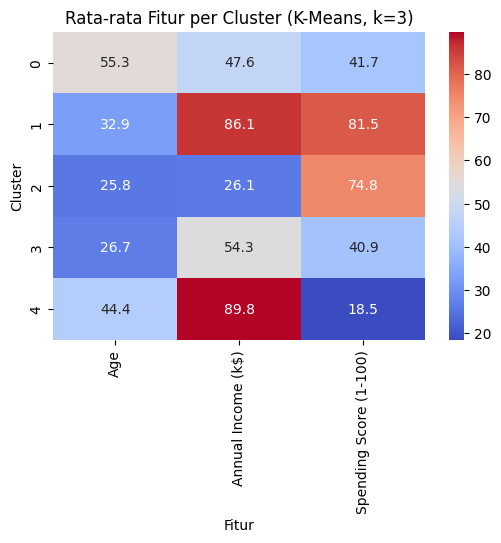

In [ ]:
# Buat DataFrame baru dengan label cluster
data_clustered = data.copy()
data_clustered['Cluster'] = kmeans.labels_

# Hitung rata-rata tiap fitur per cluster
cluster_summary = data_clustered.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()

# Tampilkan tabel ringkasan
print("Rata-rata tiap fitur per cluster:")
print(cluster_summary)

# Visualisasi heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Rata-rata Fitur per Cluster (K-Means, k=3)")
plt.xlabel("Fitur")
plt.ylabel("Cluster")
plt.show()


Kombinasi K-Means (k=10) dan fitur Age, Annual Income, Spending Score berhasil memisahkan pelanggan ke beberapa segmen yang cukup berbeda. Silhouette Score = 0,36, yang artinya kualitas cluster cukup baik tapi masih bisa ditingkatkan. Dari hasil ini fitur Spending Score sangat berpengaruh dalam membedakan kelompok pelanggan.